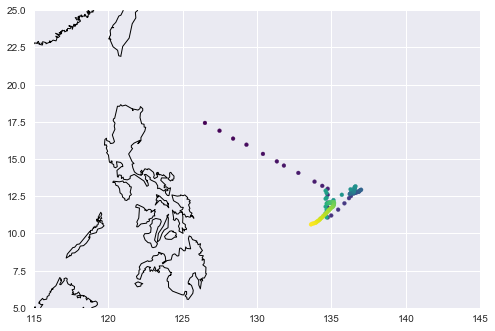

In [97]:
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 28 10:23:29 2018

@author: chudl

Updated by zan3rm
"""
from __future__ import division
import numpy as np  # NumPy (multidimensional arrays, linear algebra, ...)
import scipy as sp  # SciPy (signal and image processing library)
import matplotlib as mpl         # Matplotlib (2D/3D plotting library)
import matplotlib.pyplot as plt  # Matplotlib's pyplot: MATLAB-like syntax
from pylab import *              # Matplotlib's pylab interface
from mpl_toolkits.basemap import Basemap
import glob
from skewPy import SkewT
import pandas as pd
import seaborn as sns
sns.color_palette()


# Interpolates a single variable data_in from A SINGLE .TXT FILE onto goal_hghts
def interp_all(data_in, goal_hghts, data_str):
    data_out = np.empty([len(goal_hghts), data_in[data_str].shape[1]])
    for i in range(data_in[data_str].shape[1]):
        hght_mask = np.where(data_in['hght'][:,i].mask == False)
        data_mask = np.where(data_in[data_str][:,i].mask == False)
        data_out[:,i] = np.interp(goal_hghts, data_in['hght'][:,i][hght_mask], data_in[data_str][:,i][hght_mask])
        data_out[np.where(data_out == -999)] = np.nan
    return(data_out)

# Interpolates a data_set from full monthly data formed from many files 
def interp_all_monthly(data_set_in, goal_hghts, data_str):
    data_out = np.empty([len(goal_hghts), ntimes])
    idx_start = 0
    for i in range(len(data_set_in)):
        idx_end = idx_start + data_set_in[i]['hght'].shape[1]
        #print(data_out[:, idx_start:idx_end].shape)
        #print('goal hghts', goal_hghts)
        for j in range(idx_end - idx_start):
            hght_mask = np.where(data_set_in[i]['hght'][:,j].mask == False)
            data_mask = np.where(data_set_in[i][data_str][:,j].mask == False)
            #print('actual hghts', data_set_in[i]['hght'][:,j][hght_mask])
            #print('actual hghts shape', data_set_in[i]['hght'][:,j][hght_mask].shape)
            #print('hght_mask shape ', hght_mask[0].shape)
            #print('data_mask shape ', data_mask[0].shape)
            data_out[:, idx_start+j] = np.interp(goal_hghts, \
                                       data_set_in[i]['hght'][:,j][hght_mask], \
                                       data_set_in[i][data_str][:,j][hght_mask], left=np.nan, right=np.nan)
            #print(data_out[0, idx_start+j])
            data_out[np.where(data_out == -999)] = np.nan
        idx_start = idx_end
    return(data_out)

# Function which takes a dictionary data_in and interpolate a key data_str onto heights
# goal_hghts. Might update to have automatically cycle through dictionary keys rather than
# take data_str, but not too many variables of interest to read
def interp_all_thompson(data_in, goal_hghts, data_str):
    data_out = np.empty([len(goal_hghts), len(data_in)])
    for i in range(len(data_in)):
        #print(data_in[i]['hght'])
        #print(data_in[i][data_str])
        data_out[:,i] = np.interp(goal_hghts, data_in[i]['hght'], data_in[i][data_str])
        #print(data_in[i]['hght'].max())
        #print(goal_hghts>data_in[i]['hght'].max())
        data_out[np.where(goal_hghts>data_in[i]['hght'].max()), i] = np.nan
    return(data_out)


files = sorted(glob.glob('/Volumes/cruiseshare/Soundings/Thompson/edt/e*'))

lat = []
lon = []
for f in files:
    data = loadtxt(f,skiprows = 30)
    lat.append(data[:,9])
    lon.append(data[:,10])

start_lon = [l[0] for l in lon]    
start_lat = [l[0] for l in lat]

lonMin = 115
lonMax = 145
latMin = 5
latMax = 25


m = Basemap(llcrnrlon=lonMin, llcrnrlat=latMin, urcrnrlat=latMax, urcrnrlon=lonMax, \
            resolution = 'l', suppress_ticks=False)

colors = [mpl.cm.viridis(x) for x in np.linspace(0,1,len(files))]

m.scatter(start_lon,start_lat, s = 15, c = colors, latlon=True)
m.drawcoastlines()

In [98]:
# Main folder where the reading is done; creates list of all current soundings
file_list = files
#print('List of soundings: ', file_list)
#print('Most current sounding: ', file_list[-1])

S1 = SkewT.Sounding(data={}, fmt='PISTON_EDT', init_plot=0)
#S1.make_skewt_axes()
data_set = ()
date_list = ()

for file_name,idx in zip(file_list, np.arange(len(file_list))):
    S1.readfile(file_name)
    #S1.add_profile(color=clrs[-idx], bloc=.6 + .2*idx, bcol=clrs[-idx])
    data_set = np.append(data_set, S1.data)
    date_list = np.append(date_list, S1.sounding_date)

# Sets up goal heights up to 20km and interpolate tempa nd dewpt
z = np.linspace(0, 17000, 300)

# Calculates zonal and meridional wind from the speed and direction
u = np.empty([len(z), len(data_set)])
v = np.empty(u.shape)

# More interpolation
for i in range(len(data_set)):
    utemp = data_set[i]['sknt']*np.cos(np.radians(270-data_set[i]['drct']))
    vtemp = data_set[i]['sknt']*np.sin(np.radians(270-data_set[i]['drct']))
    utemp = np.interp(z, data_set[i]['hght'], utemp)
    vtemp = np.interp(z, data_set[i]['hght'], vtemp)
    utemp[np.where(z>data_set[i]['hght'].max())] = np.nan
    vtemp[np.where(z>data_set[i]['hght'].max())] = np.nan
    u[:,i] = utemp
    v[:,i] = vtemp
#print(u)


In [99]:
# Sets up goal heights up to 20km and interpolate tempa nd dewpt
pres = np.linspace(100, 1000, 200)

# Calculates zonal and meridional wind from the speed and direction
u = np.empty([len(pres), len(data_set)])
v = np.empty(u.shape)

# More interpolation
for i in range(len(data_set)):
    utemp = data_set[i]['sknt']*np.cos(np.radians(270-data_set[i]['drct']))
    vtemp = data_set[i]['sknt']*np.sin(np.radians(270-data_set[i]['drct']))
    utemp = np.interp(pres[::-1], data_set[i]['pres'][::-1], utemp[::-1])
    vtemp = np.interp(pres[::-1], data_set[i]['pres'][::-1], vtemp[::-1])
    #utemp[np.where(pres>data_set[i]['pres'].max())] = np.nan
    #vtemp[np.where(pres>data_set[i]['pres'].max())] = np.nan
    u[:,i] = utemp[::-1]
    v[:,i] = vtemp[::-1]

tom_u850 = u[np.argmin(abs(pres - 850)), :]
tom_u200 = u[np.argmin(abs(pres - 200)), :]

tom_v850 = v[np.argmin(abs(pres - 850)), :]
tom_v200 = v[np.argmin(abs(pres - 200)), :]

In [106]:
####################################
# Processes Palau for August 2018 #
####################################

pal_lon = 134.48
pal_lat = 7.34

file_list = ('/Volumes/cruiseshare/Soundings/Palau/91408_KororPalau/201808.txt', \
                 '/Volumes/cruiseshare/Soundings/Palau/91408_KororPalau/201809.txt')

ntimes = 0 #number of days
for file_name in file_list:
    S1 = SkewT.Sounding(file_name, fmt='PALAU', date_to_read = 0, init_plot = 0)
    ntimes = ntimes + S1.data['temp'].shape[1]
#print(ntimes)

# For reading in the data_str from the dictionary
def read_all(file_list):
    data_out = list()
    for file_name in file_list:
        S1 = SkewT.Sounding(data={}, fmt='PALAU', date_to_read = 0, init_plot=0)
        S1.readfile(file_name)
        data_out.append(S1.data)
    return(data_out)

def read_dates(file_list):
    data_out = np.empty(ntimes, dtype=datetime.datetime)
    idx_start = 0
    for file_name in file_list:
        S1 = SkewT.Sounding(file_name, fmt='PALAU', date_to_read = 0, init_plot=0)
        idx_end = idx_start + np.asarray(S1.sounding_date).shape[0]
        data_out[idx_start:idx_end] = np.asarray(S1.sounding_date)
        idx_start = idx_end

    return(data_out)
#S1.fig.legend()

palau_list = read_all(file_list)
pal_dates = read_dates(file_list)
# Reads Palau for August

#temp = np.empty(palau['temp'].shape)
z = np.linspace(0, 17000, 300)
#for i in range(len(z)palau['hght'].shape[1]):
#    temp[:,i] = np.interp(z, palau['hght'][:,i], palau['temp'][:,i])
    #dwpt = interp_all(palau, z, 'dwpt')
    #pres = interp_all(palau, z, 'pres')

pal_temp = interp_all_monthly(palau_list, z, 'temp')
pal_dwpt = interp_all_monthly(palau_list, z, 'dwpt')
pal_sknt = interp_all_monthly(palau_list, z,'sknt')
pal_drct = interp_all_monthly(palau_list, z,'drct')
#pal_dwpt[np.where((pal_dwpt > 50.) | (pal_dwpt < -100))] = np.nan


pal_relh = SkewT.RH(pal_temp, pal_dwpt)
pal_u = pal_sknt*np.cos(np.radians(270-pal_drct))
pal_v = pal_sknt*np.sin(np.radians(270-pal_drct))

# Some data management


pal_u850 = pal_u[np.argmin(abs(pres - 850)), :]
pal_u200 = pal_u[np.argmin(abs(pres - 200)), :]

pal_v850 = pal_v[np.argmin(abs(pres - 850)), :]
pal_v200 = pal_v[np.argmin(abs(pres - 200)), :]

pal_lon = 134.48
pal_lat = 7.34

pal_u850 = pal_u850[79:]
pal_u200 = pal_u200[79:]

pal_v850 = pal_v850[79:]
pal_v200 = pal_v200[79:]



In [108]:
pal_dates

array([datetime.datetime(2018, 8, 1, 0, 0),
       datetime.datetime(2018, 8, 1, 6, 0),
       datetime.datetime(2018, 8, 1, 12, 0),
       datetime.datetime(2018, 8, 1, 18, 0),
       datetime.datetime(2018, 8, 2, 0, 0),
       datetime.datetime(2018, 8, 2, 6, 0),
       datetime.datetime(2018, 8, 2, 12, 0),
       datetime.datetime(2018, 8, 2, 18, 0),
       datetime.datetime(2018, 8, 3, 0, 0),
       datetime.datetime(2018, 8, 3, 6, 0),
       datetime.datetime(2018, 8, 3, 12, 0),
       datetime.datetime(2018, 8, 3, 18, 0),
       datetime.datetime(2018, 8, 4, 0, 0),
       datetime.datetime(2018, 8, 4, 6, 0),
       datetime.datetime(2018, 8, 4, 12, 0),
       datetime.datetime(2018, 8, 4, 18, 0),
       datetime.datetime(2018, 8, 5, 0, 0),
       datetime.datetime(2018, 8, 5, 6, 0),
       datetime.datetime(2018, 8, 5, 12, 0),
       datetime.datetime(2018, 8, 5, 18, 0),
       datetime.datetime(2018, 8, 6, 0, 0),
       datetime.datetime(2018, 8, 6, 6, 0),
       datetime.dateti

In [109]:
####################################
# Processes Yap for August 2018 #
####################################
yap_lat = 9.50
yap_lon = 138.08

file_list = ('/Volumes/cruiseshare/Soundings/Yap/201808.txt', '/Volumes/cruiseshare/Soundings/Yap/201809.txt')

ntimes = 0 #number of days
for file_name in file_list:
    S1 = SkewT.Sounding(file_name, fmt='PALAU', date_to_read = 0, init_plot = 0)
    ntimes = ntimes + S1.data['temp'].shape[1]
#print(ntimes)

#S1.fig.legend()

yap_list = read_all(file_list)
yap_dates = read_dates(file_list)

yap_temp = interp_all_monthly(yap_list, z, 'temp')
yap_dwpt = interp_all_monthly(yap_list, z, 'dwpt')
yap_sknt = interp_all_monthly(yap_list, z, 'sknt')
yap_drct = interp_all_monthly(yap_list, z, 'drct')

# Some data management
yap_dwpt[np.where((yap_dwpt > 50.) | (yap_dwpt < -100))] = np.nan

yap_relh = SkewT.RH(yap_temp, yap_dwpt)
yap_u = yap_sknt*np.cos(np.radians(270-yap_drct))
yap_v = yap_sknt*np.sin(np.radians(270-yap_drct))

yap_u850 = yap_u[np.argmin(abs(pres - 850)), :]
yap_u200 = yap_u[np.argmin(abs(pres - 200)), :]

yap_v850 = yap_v[np.argmin(abs(pres - 850)), :]
yap_v200 = yap_v[np.argmin(abs(pres - 200)), :]

yap_lat = 9.50
yap_lon = 138.08

yap_u850 = yap_u850[40:]
yap_u200 = yap_u200[40:]

yap_v850 = yap_v850[40:]
yap_v200 = yap_v200[40:]

/Users/zanemartin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in greater
/Users/zanemartin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in less


In [110]:
tom_ordd = np.asarray([date_list[i].timestamp() for i in range(len(date_list))])
pal_ordd = np.asarray([palau_dates[i].timestamp() for i in range(len(palau_dates))])
yap_ordd = np.asarray([yap_dates[i].timestamp() for i in range(len(yap_dates))])

yap_u850_int = np.interp(pal_ordd[79::], yap_ordd[40::], yap_u850)
tom_u850_int = np.interp(pal_ordd[79::], tom_ordd, tom_u850)

yap_v850_int = np.interp(pal_ordd[79::], yap_ordd[40::], yap_v850)
tom_v850_int = np.interp(pal_ordd[79::], tom_ordd, tom_v850)

yap_u200_int = np.interp(pal_ordd[79::], yap_ordd[40::], yap_u200)
tom_u200_int = np.interp(pal_ordd[79::], tom_ordd, tom_u200)

yap_v200_int = np.interp(pal_ordd[79::], yap_ordd[40::], yap_v200)
tom_v200_int = np.interp(pal_ordd[79::], tom_ordd, tom_v200)

tom_lon_int = np.interp(pal_ordd[79::], tom_ordd, np.asarray(start_lon))
tom_lat_int = np.interp(pal_ordd[79::], tom_ordd, np.asarray(start_lat))

/Users/zanemartin/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


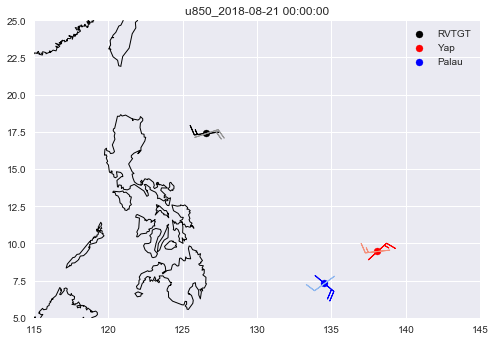

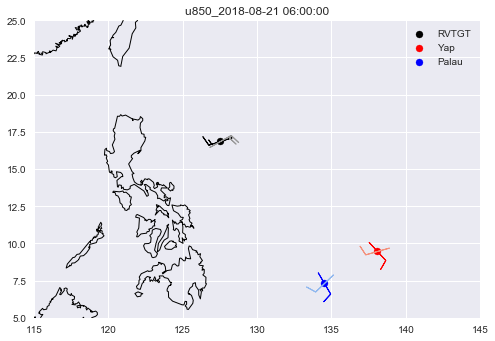

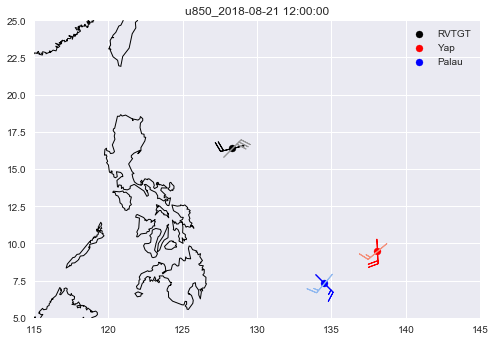

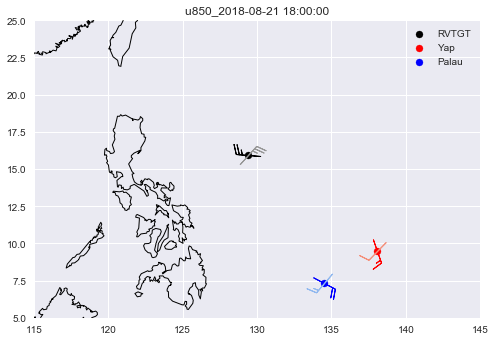

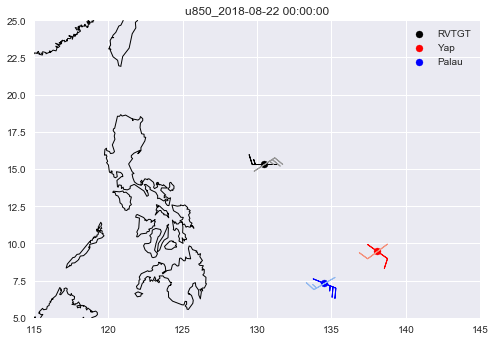

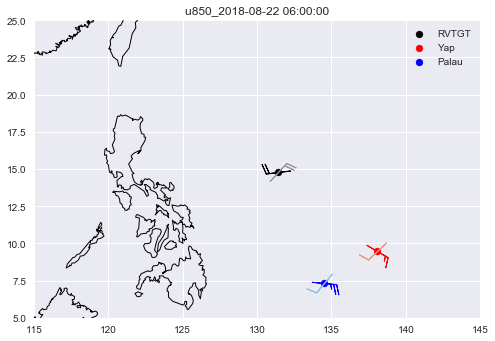

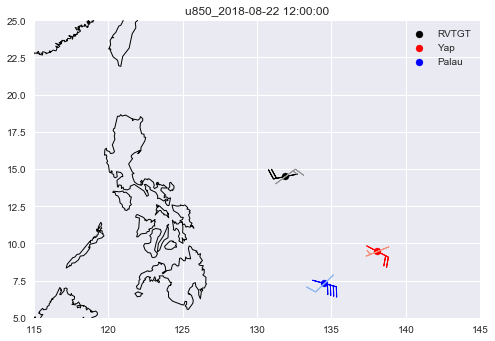

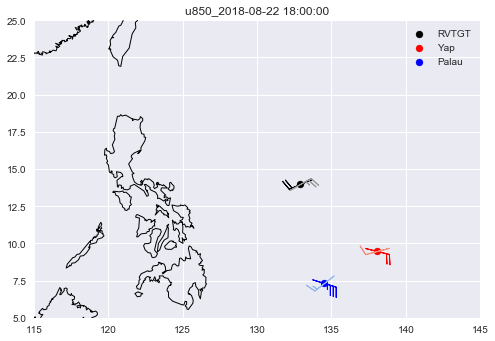

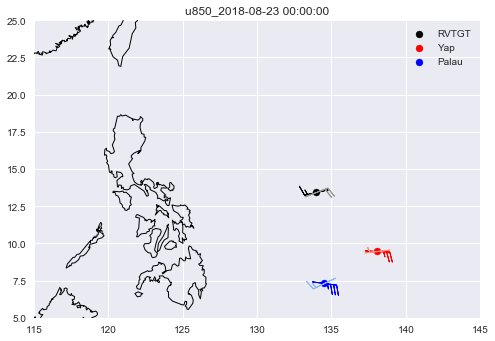

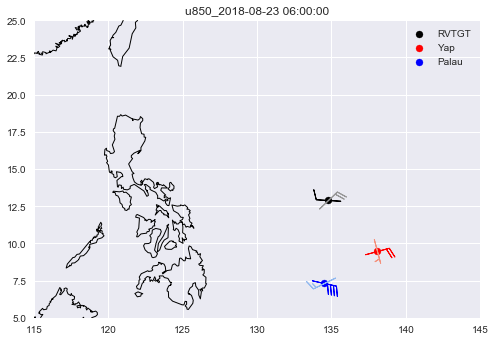

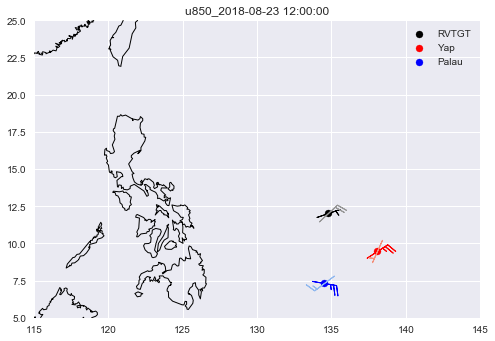

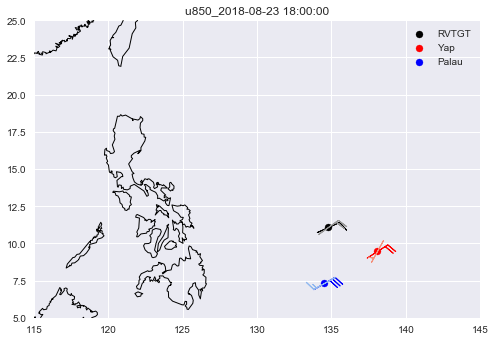

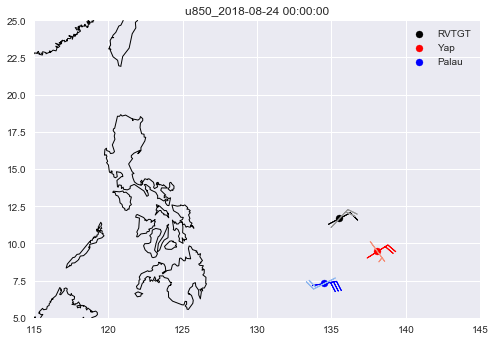

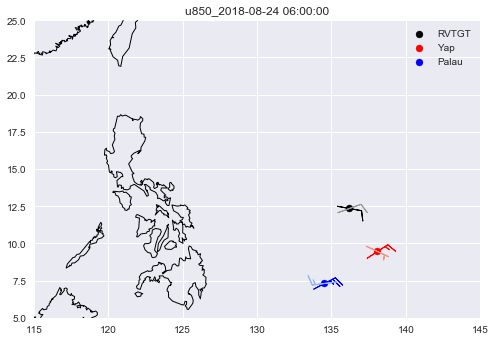

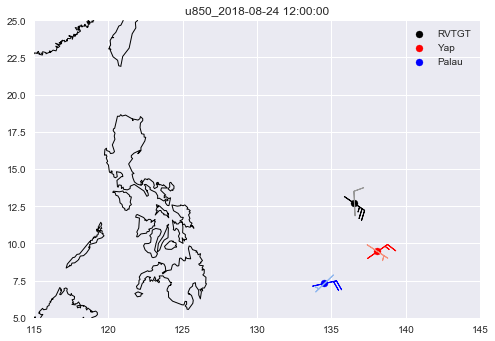

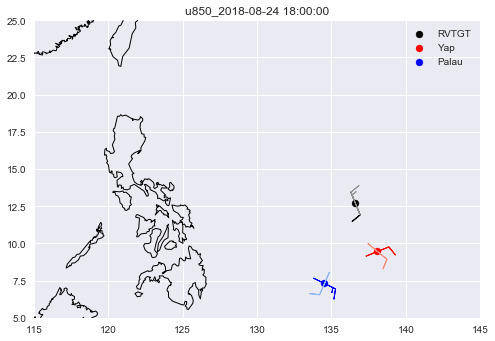

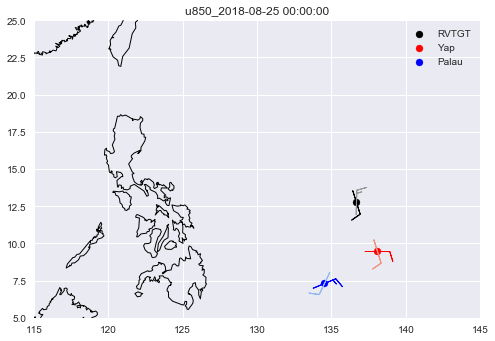

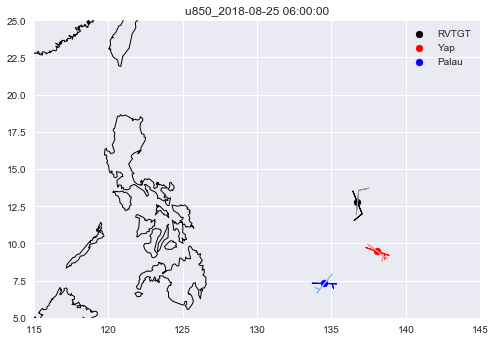

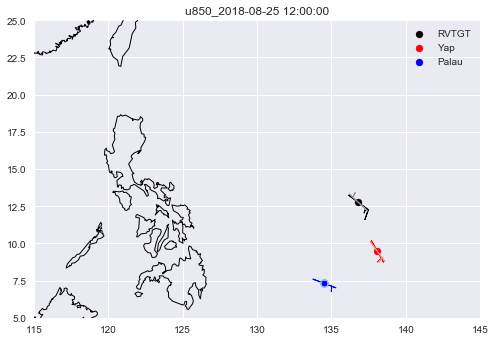

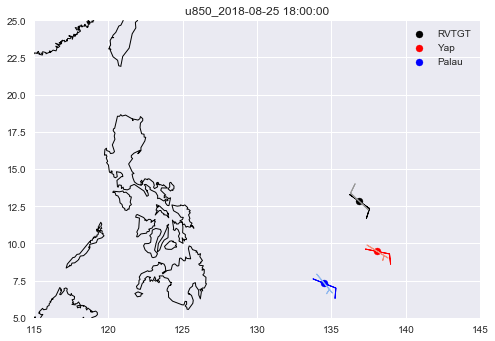

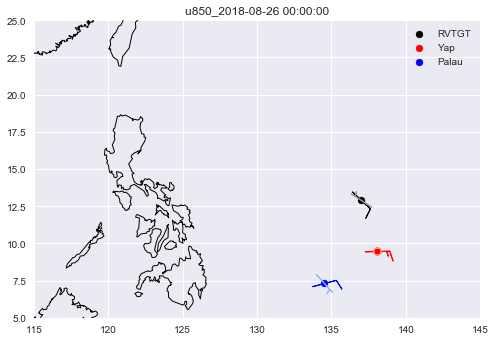

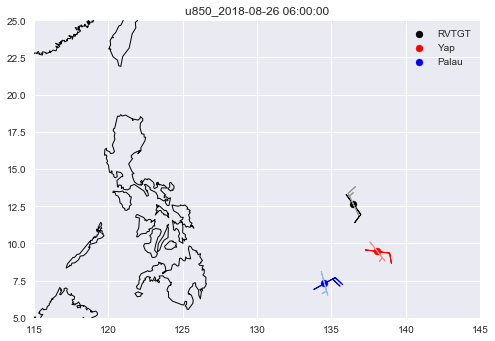

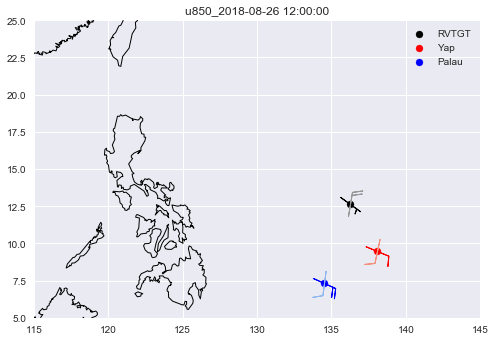

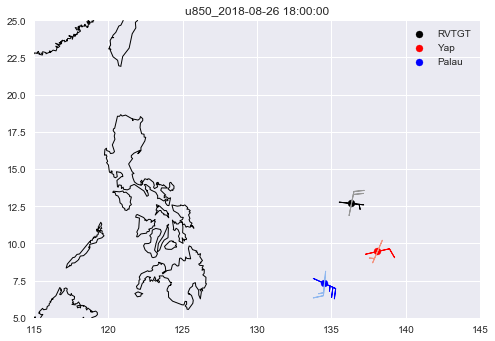

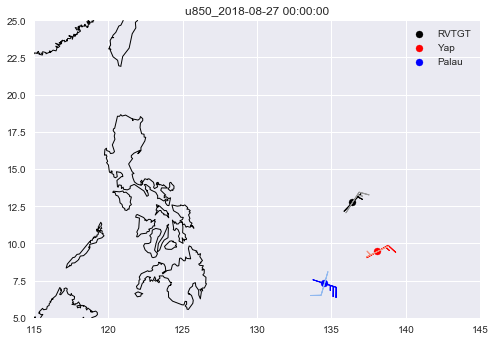

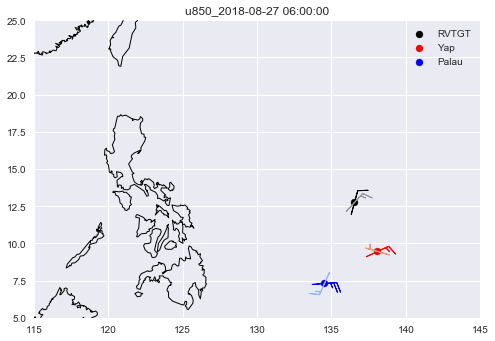

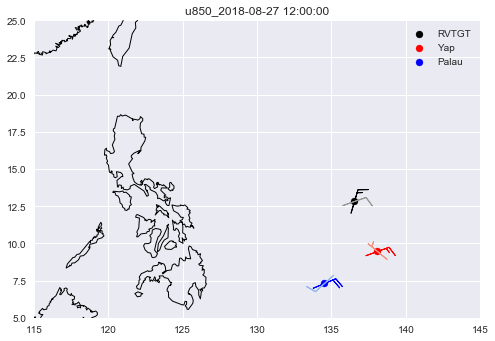

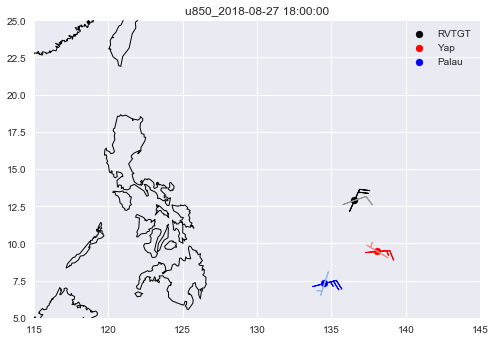

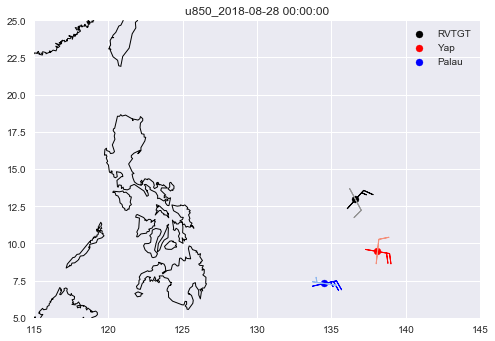

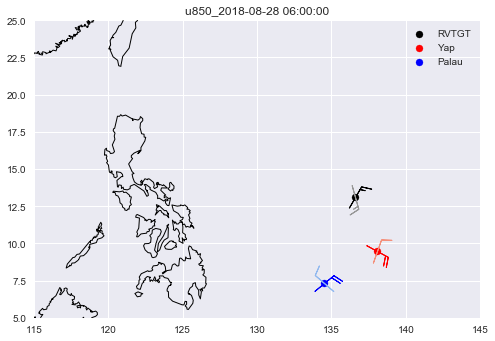

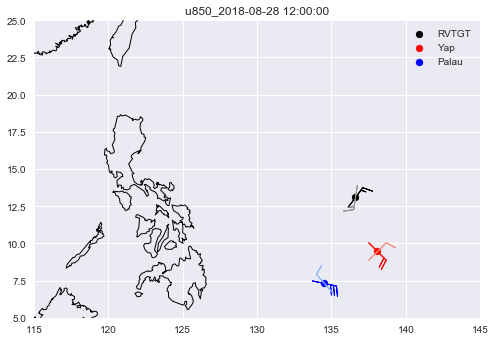

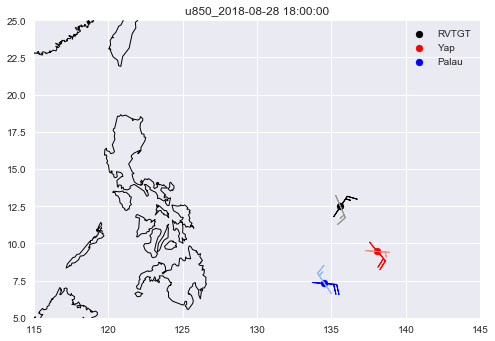

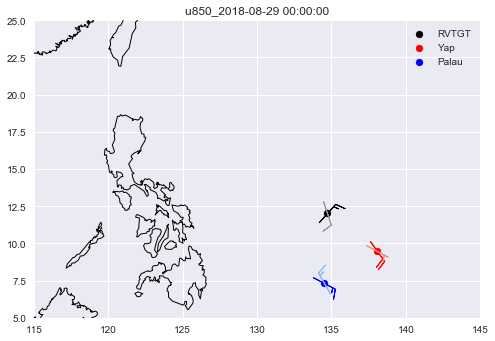

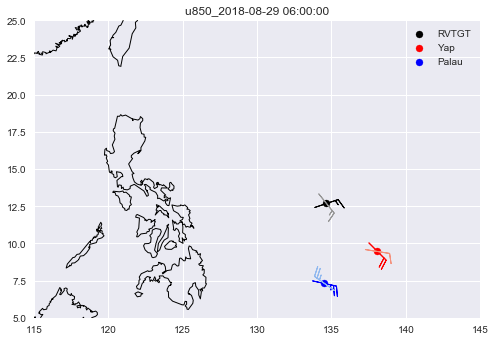

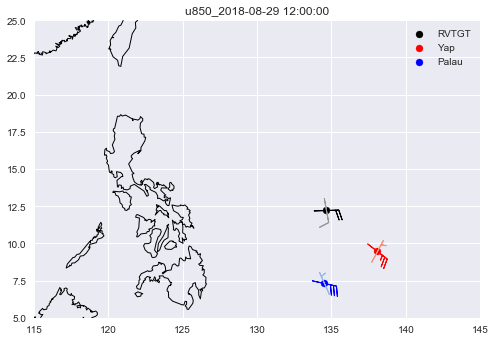

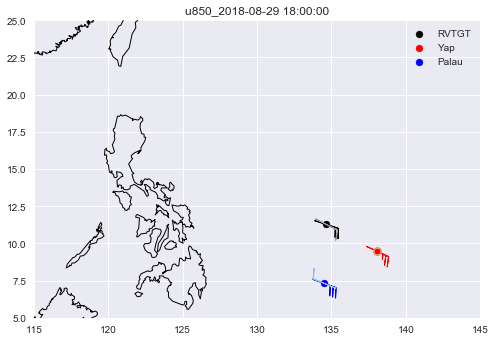

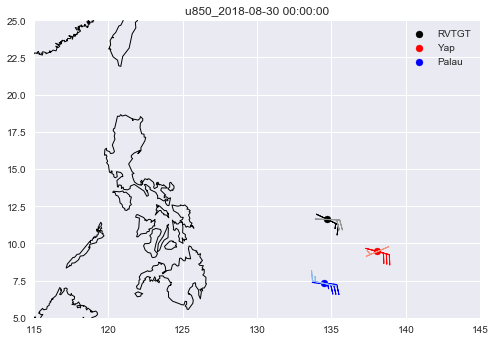

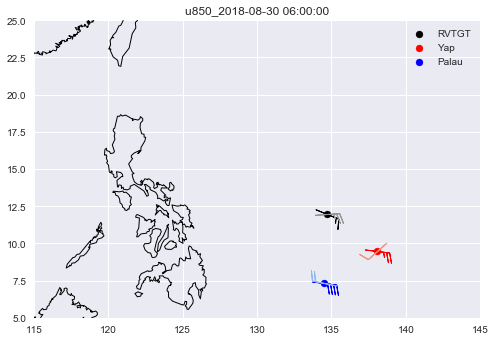

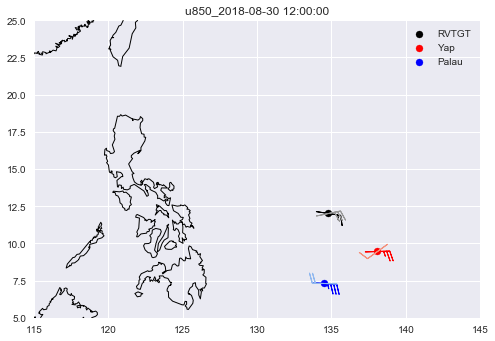

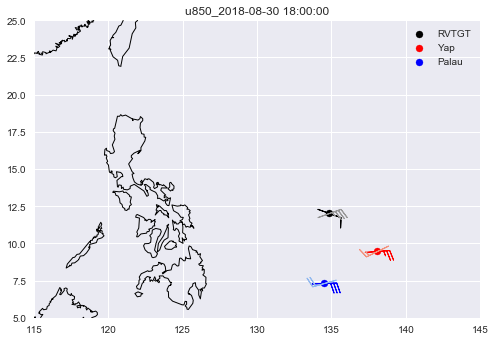

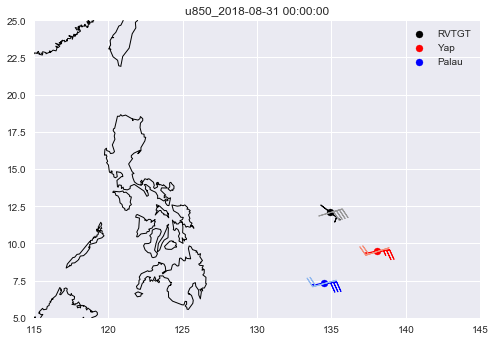

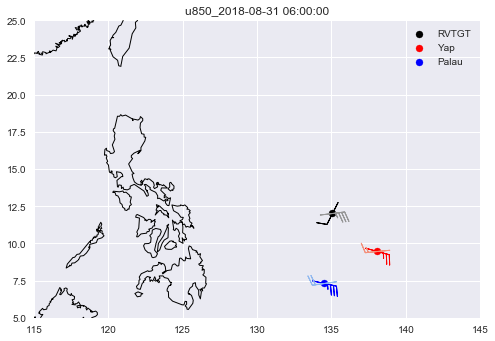

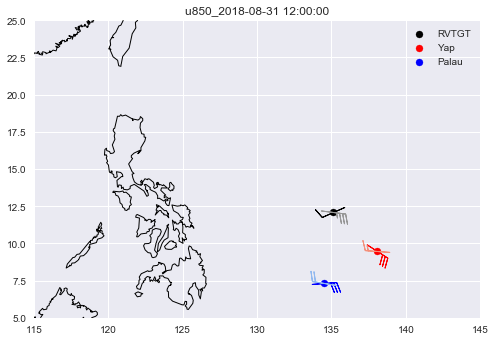

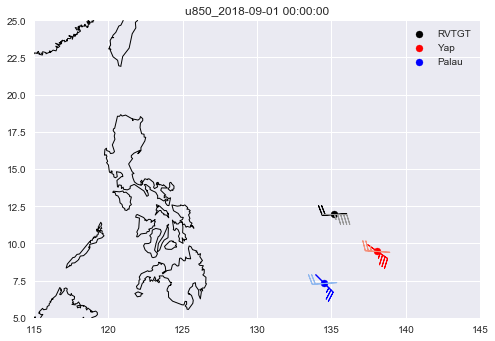

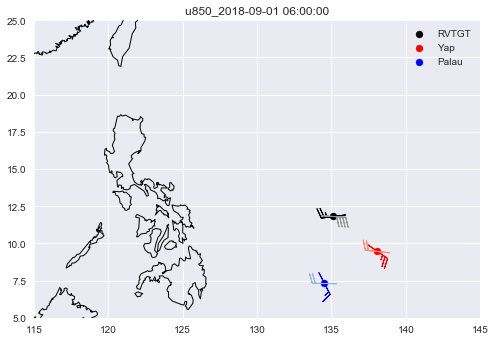

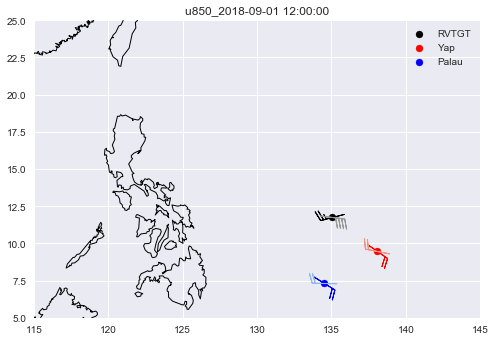

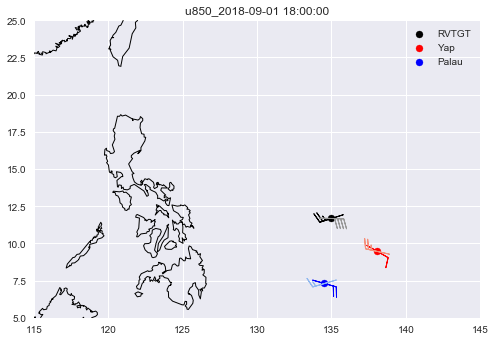

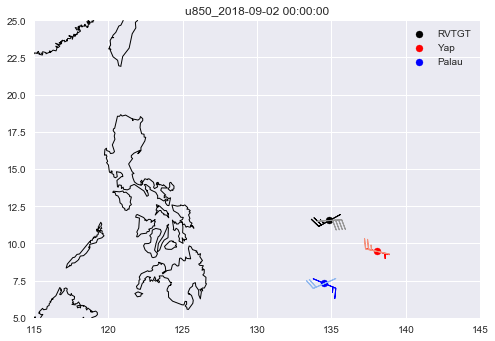

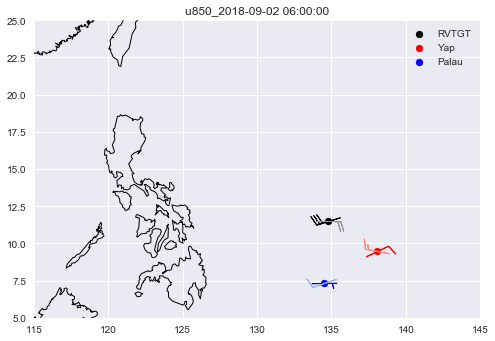

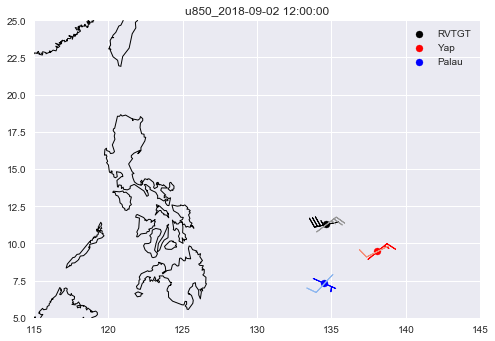

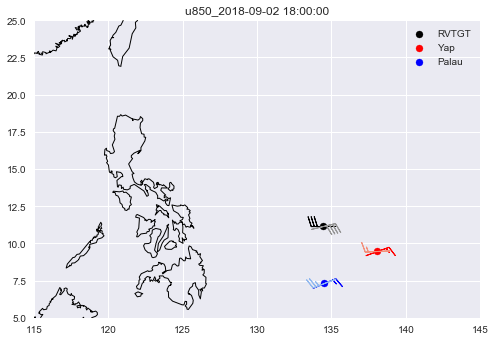

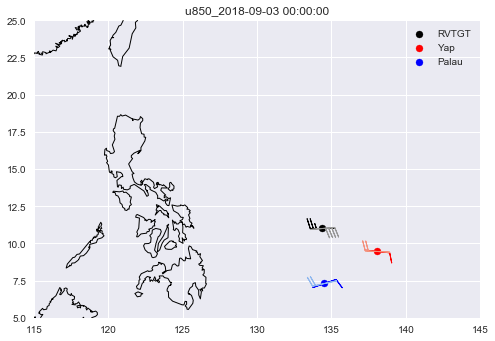

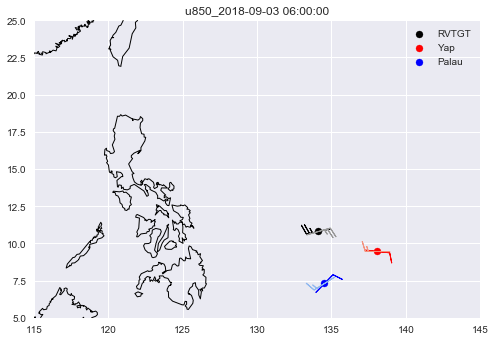

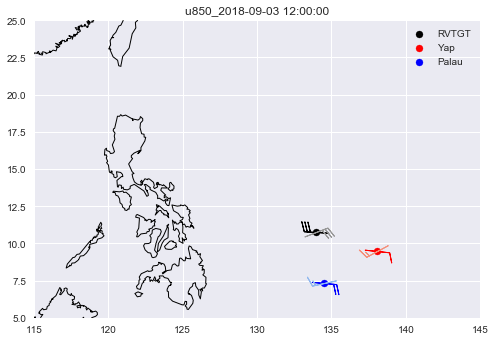

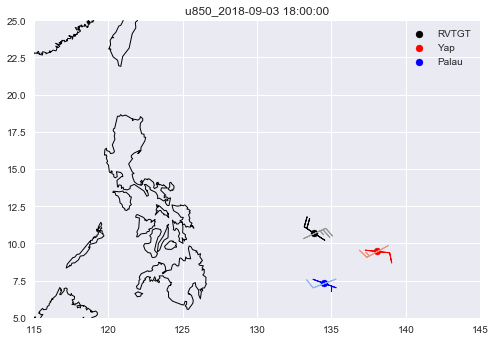

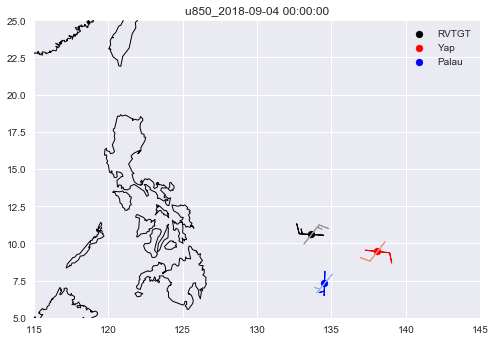

In [111]:
plt.close('all')
for i in range(len(pal_ordd[79::])):
    u2mean = (tom_u200_int[i] + yap_u200_int[i] + pal_u200[i])/3
    v2mean = (tom_v200_int[i] + yap_v200_int[i] + pal_v200[i])/3
    fig = figure()
    m.scatter(tom_lon_int[i],tom_lat_int[i], color='k', label='RVTGT')
    m.scatter(yap_lon,yap_lat, color='r', label='Yap')
    m.scatter(pal_lon,pal_lat, color='b', label='Palau')
    m.barbs(tom_lon_int[i], tom_lat_int[i], tom_u850_int[i], tom_v850_int[i], pivot = 'middle', color='k')
    m.barbs(yap_lon, yap_lat, yap_u850_int[i], yap_v850_int[i], pivot = 'middle', color='r')
    m.barbs(pal_lon, pal_lat, pal_u850[i], pal_v850[i] , pivot = 'middle', color='b')
    m.barbs(tom_lon_int[i], tom_lat_int[i], tom_u200_int[i] - u2mean, tom_v200_int[i] - v2mean, pivot = 'middle', color='#979797')
    m.barbs(yap_lon, yap_lat, yap_u200_int[i] - u2mean, yap_v200_int[i] - v2mean, pivot = 'middle', color='#F4907B')
    m.barbs(pal_lon, pal_lat, pal_u200[i] - u2mean, pal_v200[i] - v2mean, pivot = 'middle', color='#90B8EF')
    m.drawcoastlines()
    plt.legend()
    plt.title('u850_' + str(pal_dates[79::][i]))
    if i <= 9:
        fig.savefig('./images/u850_u200_0' + str(i) + '.png',dpi=100)
    else:
        fig.savefig('./images/u850_u200_' + str(i) + '.png',dpi=100)